In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)


In [3]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [4]:
y.shape

(70000,)

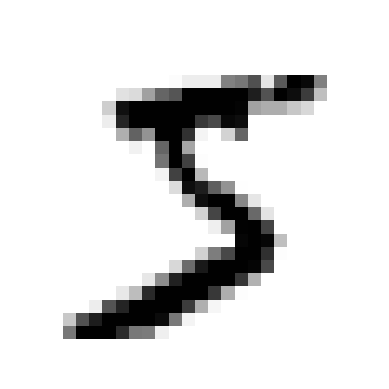

In [5]:
import matplotlib.pyplot as plt

def plot_image(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
some_digit = X[0]
plot_image(some_digit)

In [6]:
y[0]

'5'

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
y_train_5= (y_train == '5')
y_test_5 = (y_test == '5')

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [11]:
from sklearn.dummy import DummyClassifier
dummy_clf= DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))


False


In [12]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

extra code for custom cross validation


In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

def get_my_scores(clf, X, y):
    my_scores = []
    for train_index, test_index in skfolds.split(X, y):
        clone_clf = clone(clf)
        X_train_folds = X[train_index]
        y_train_folds = y[train_index]
        X_test_fold = X[test_index]
        y_test_fold = y[test_index]

        clone_clf.fit(X_train_folds, y_train_folds)

        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        my_scores.append(n_correct / len(y_pred))
    return my_scores

get_my_scores(sgd_clf, X_train, y_train_5)

[np.float64(0.9669), np.float64(0.91625), np.float64(0.96785)]

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3 )
cf = confusion_matrix(y_train_5, y_train_pred)
cf

array([[53892,   687],
       [ 1891,  3530]])

In [15]:
from sklearn.metrics import precision_score, recall_score



In [16]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [17]:

recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
threshold = 2500
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

so how do we figure out which threshold to use? well, look at the codes below. 

In [21]:
y_scores = cross_val_predict( sgd_clf, X_train, y_train_5, cv=3 , method="decision_function" )


In [22]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)                                                                                             

In [23]:
from matplotlib import pyplot as plt
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='precisions', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label= 'recalls', linewidth=2)
    plt.vlines(threshold, 0, 1, "b", 'dotted', label='threshold')
    plt.xlabel('Threshold')
    plt.legend(loc='center right')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs Threshold')
    plt.grid()
    plt.show()

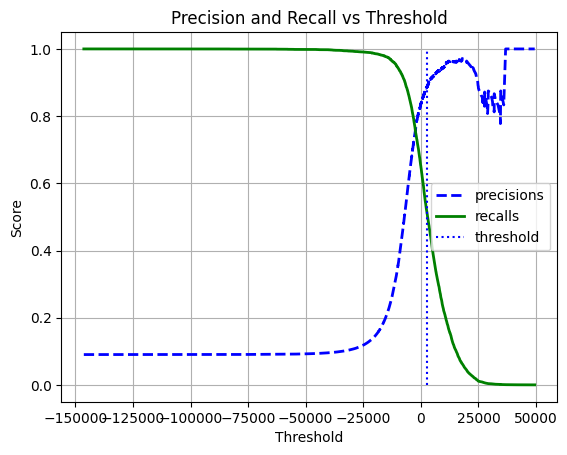

In [24]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

lets see another graph to  make our decision more educated!

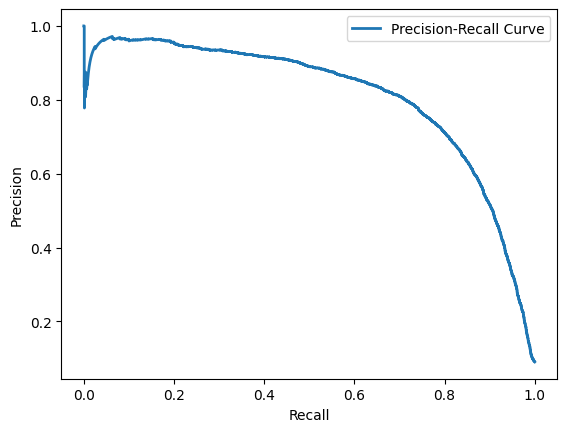

In [25]:
plt.plot(recalls, precisions, label='Precision-Recall Curve', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')

In [26]:
# so how do we figure out which threshold to use? well, look at the codes below.
import numpy as np
idx_for_90_precision = np.argmax(precisions >= 0.90)
threshold = thresholds [idx_for_90_precision]
threshold

np.float64(3370.019499143956)

In [27]:
# so how do we figure out which threshold to use? well, look at the codes below. contd..
y_train_pred_90 = (y_scores >= threshold)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)



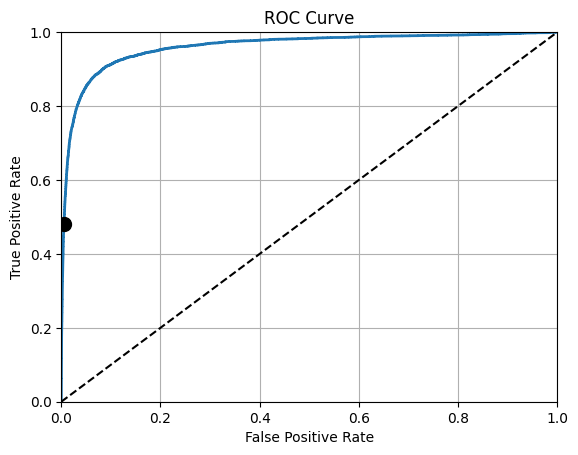

In [30]:
idx_for_threshold_at_90 = (thresholds <= threshold).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label = 'ROC Curve')
plt.plot(fpr_90, tpr_90, 'ko', markersize=10, label ='threshold at 90% ptrcision')
plt.plot([0,1], [0,1], 'k--', label= 'Random Classifiers ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.axis([0,1,0,1])
plt.grid()

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [32]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)

In [33]:
clf_proba = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = 'predict_proba')


In [34]:
clf_proba[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

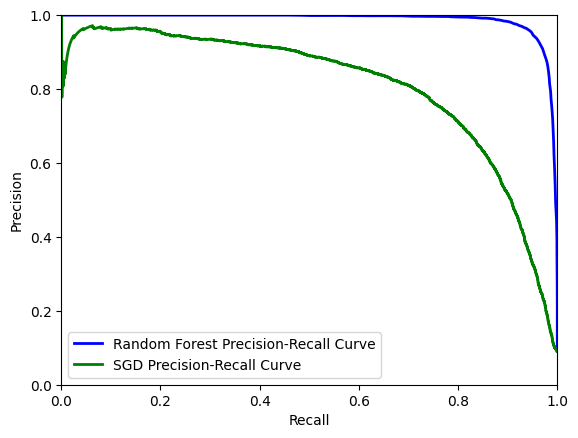

In [35]:
forest_y_scores = clf_proba[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, forest_y_scores)
plt.plot(recalls_forest, precisions_forest,'-b', label='Random Forest Precision-Recall Curve', linewidth=2)
plt.plot(recalls, precisions, '-g', label='SGD Precision-Recall Curve', linewidth=2)
plt.xlabel('Recall')
plt.axis([0, 1, 0, 1])
plt.ylabel('Precision')
plt.legend(loc='best')

In [36]:
y_train_pred_forest = (forest_y_scores >= 0.5)
roc_auc_score(y_train_5, y_train_pred_forest)

0.9358174809192218

Text(0.5, 1.0, 'ROC Curve')

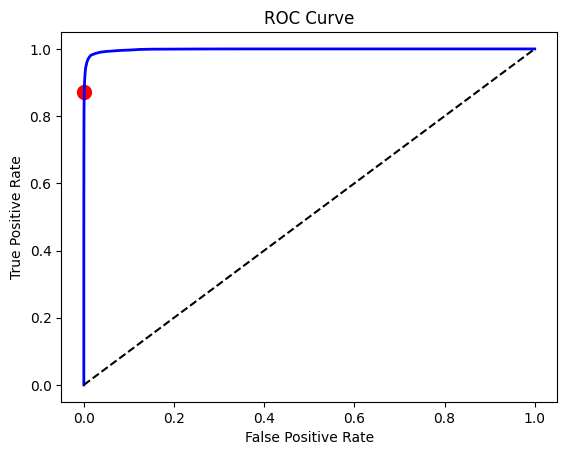

In [37]:
forest_fpr, forest_tpr, forest_thresholds = roc_curve(y_train_5, clf_proba[:, 1])
idx_for_threshold_at_90 = (forest_thresholds <= 0.5).argmax()
fpr_90_forest, tpr_90_forest = forest_fpr[idx_for_threshold_at_90], forest_tpr[idx_for_threshold_at_90]
plt.plot(fpr_90_forest, tpr_90_forest, 'ro', label='Random Forest ROC Curve at 90% threshold', markersize=10)
plt.plot(forest_fpr, forest_tpr, '-b', label='Random Forest ROC Curve', linewidth=2)
plt.plot([0,1], [0,1], 'k--', label='Random Classifiers ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

## MultiClass Classification

In [38]:
from sklearn.svm import SVC
svc_clf = SVC(gamma='auto', random_state=42)
svc_clf.fit(X_train[:1000], y_train[:1000]) #note : here we are fitting the SVC classifier to the original y_train labels, not the y_train_5 labels
some_digit = X[0]
svc_clf.predict([some_digit])

array(['5'], dtype=object)

In [39]:
some_digit_scores = svc_clf.decision_function([some_digit])
some_digit_scores 

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [40]:
np.argmax(some_digit_scores)

np.int64(5)

In [41]:
svc_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

now we force the model to use OvR strategy
basically a 0detector, 1detector and so on (this is preferred for most of the models)

In [42]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma='auto', random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [43]:
ovr_clf.decision_function([some_digit])

array([[-0.9990256 , -0.99963766, -0.99949709, -0.99902667, -0.99986906,
         0.10132159, -0.99976287, -0.99933311, -0.99943631, -0.99924045]])

In [44]:
sgd_clf.fit(X_train[:1000], y_train[:1000])
sgd_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [45]:
sgd_clf.decision_function([some_digit])

array([[-6049581.97985829, -6138036.45541781, -3886281.38604605,
         -604692.42366776, -6948311.32017537,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

plotting confusion matrix

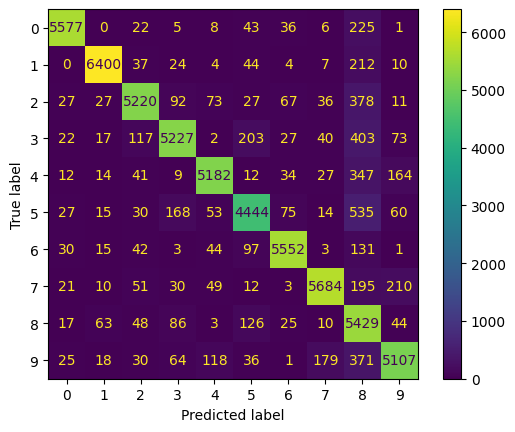

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3 )   
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

watching the predictions on percentage (of each rows sum) will be more fun..

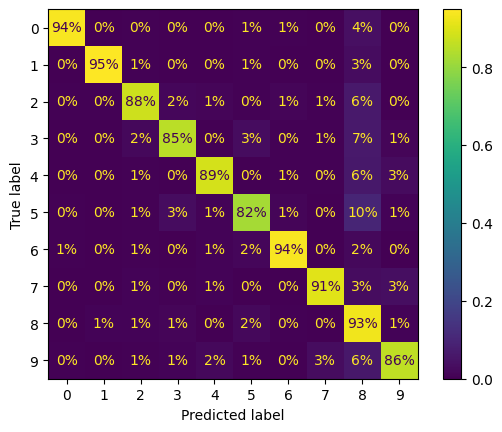

In [48]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format='.0%')

we can see a lot of predictions were wrongly classified as 8!

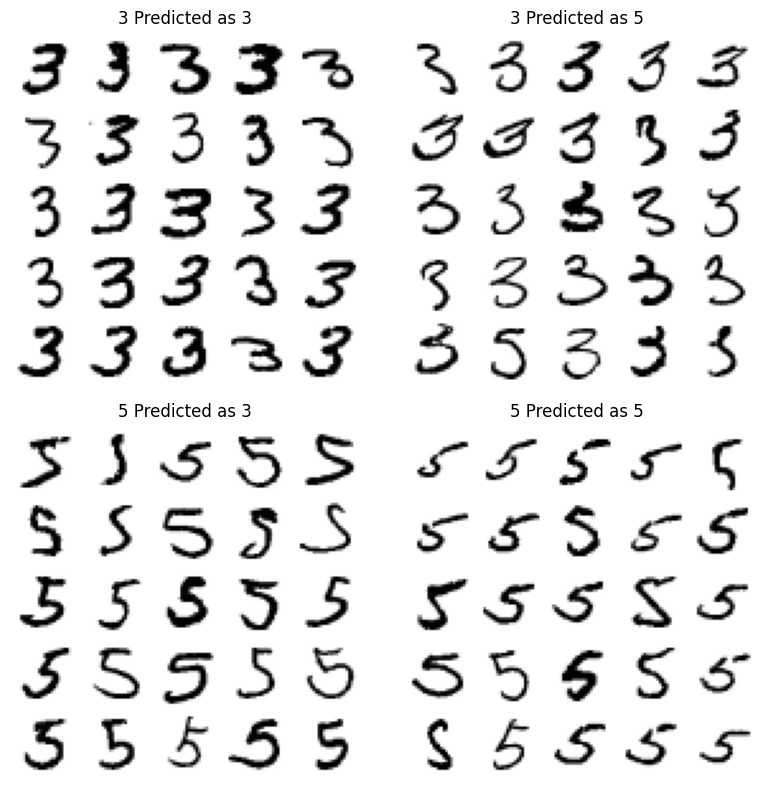

In [49]:
def make_grid(X, n=25, cols=5, size=28):
    n_items = min(n, len(X))
    if n_items == 0:
        return np.zeros((size, size))
    rows = (n_items + cols - 1) // cols
    grid = np.zeros((rows * size, cols * size))
    for i in range(n_items):
        r, c = divmod(i, cols)
        grid[r*size:(r+1)*size, c*size:(c+1)*size] = X[i].reshape(size, size)
    return grid

cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

#plot all images in x_aa, x_ab, x_ba, x_bb in confusion matrix style in a single figure

ig, axes = plt.subplots(2, 2, figsize=(8, 8))

axes[0, 0].imshow(make_grid(X_aa), cmap='binary'); axes[0, 0].set_title(f"{cl_a} Predicted as {cl_a} "); axes[0, 0].axis('off')
axes[0, 1].imshow(make_grid(X_ab), cmap='binary'); axes[0, 1].set_title(f"{cl_a} Predicted as {cl_b} "); axes[0, 1].axis('off')
axes[1, 0].imshow(make_grid(X_ba), cmap='binary'); axes[1, 0].set_title(f"{cl_b} Predicted as {cl_a} "); axes[1, 0].axis('off')
axes[1, 1].imshow(make_grid(X_bb), cmap='binary'); axes[1, 1].set_title(f"{cl_b} Predicted as {cl_b} "); axes[1, 1].axis('off')


plt.tight_layout()
plt.show()


Multilabel Classifier

In [50]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
train_large = ('7'<= y_train)
train_odd = (y_train.astype(int) % 2 == 1)

y_multilabel = np.c_[train_large, train_odd]

In [51]:
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
from sklearn.metrics import f1_score
y_train_pred_knn = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_pred_knn, average='weighted')

what if we want to use a binary classifier like SVC to predict multilabel?

In [ ]:
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])
chain_clf.predict([some_digit])

array([[0., 1.]])

Multioutput Classification

In [ ]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise


In [ ]:
y_train_mod = X_train  # clean images (targets)
y_test_mod = X_test

<function matplotlib.pyplot.show(close=None, block=None)>

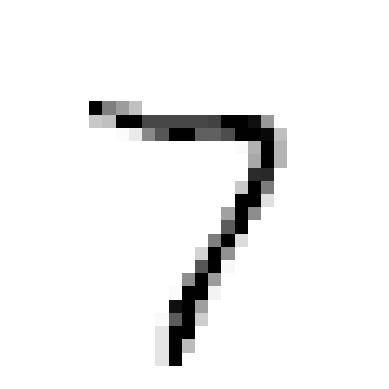

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
cleaned_digit = knn_clf.predict([X_test_mod[0]])
plot_image(cleaned_digit)
plt.show